In [2]:
import numpy as np
import pandas as pd
import pylab
import seaborn as sns

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from statsmodels.formula.api import logit

%matplotlib inline

np.set_printoptions(precision=5, suppress= True)

from google.colab import drive
drive.mount('/content/drive/',force_remount=True)
mydir = "/content/drive/My Drive/Courses/25_1st_Statistical Learning/HW/"
!ls "/content/drive/My Drive/Courses/25_1st_Statistical Learning/HW/"


Mounted at /content/drive/
 Auto.csv		     'Mod_stock(Bitcoin).csv'
 BirdCancer.csv		      Mod_stock.csv
 cars.csv		     'Mod_stock(gold).csv'
'Commodity10(Beef).csv'      'Mod_US Stock Market Dataset_2.csv'
'Commodity10(Crudeoil).csv'  'Mod_US Stock Market Dataset.csv'
'Commodity2_10(Beef).csv'     NYSE.csv
'Commodity(Crudeoil).csv'     pendigits.tra
 FEV.csv		      Pima.csv
 Hitters1.csv		      Prob4-2.csv
 Hw1.ipynb		      Project_Stock_Diff.ipynb
 HW1_SS.ipynb		      Project_Stock.ipynb
 HW2_SS.ipynb		      Project_Stock_MA_useless.ipynb
 HW3_SS.ipynb		      Project_Stock_Mult.ipynb
 HW4_SS.ipynb		      Project_Stock_MV.ipynb
 HW5_SS.ipynb		      Project_Stock_original.ipynb
 HW6_SS.ipynb		      Project_Stock_Univ_bias.ipynb
 HW7_2_SS.ipynb		      Project_Stock_Univ.ipynb
 HW7_SS.ipynb		      Sev_temp4.csv
 HW8_SS.ipynb		     'US Stock Market Dataset.csv'
'Mod_stock2_100(tesla).csv'   Xdata.pkl
'Mod_stock7(Tesla).csv'       ydata.pkl


# RNN_multivariate (stock)

In [39]:
# multivariate only using Tesla stock and filtered Crude_oil

St_data_ori = pd.read_csv(mydir + 'Mod_US Stock Market Dataset_2.csv')
St_data = St_data_ori[::-1].reset_index(drop=True)
dataM_raw = St_data.drop(['No','Date'], axis=1).astype('float64')
print(dataM_raw)
dataM_raw = dataM_raw[['Tesla']]  #bad: , good: , 'Bitcoin' ,'Crude_oil'(loss: 0.0070 - val_loss: 0.0297),'S&P_500'(loss: 0.0079 - val_loss: 0.0100),'Gold'(loss: 0.0232 - val_loss: 0.0309), Not tested: ,
Target_IDX = dataM_raw.columns.get_loc("Tesla")

dataM_Unscale = dataM_raw.to_numpy()
# since each variable is on its own scale, it's a good idea to scale them first

from sklearn.preprocessing import StandardScaler
scalerM = StandardScaler()
dataM = scalerM.fit_transform(dataM_raw)
Start_Time = 0
Cur_Time = 517
Size_data = dataM.shape[1]

# autocorrelation function for the data
#from statsmodels.graphics.tsaplots import plot_acf

#fig, ax = plt.subplots(figsize=(10, 5))
#plot_acf(dataM_past, lags=300, ax=ax, title='Autocorrelation Function') # lags: number of lags to show

#plt.xlabel('Lag')
#plt.ylabel('Autocorrelation')
#plt.show()

     Natural_Gas  Natural_Gas_Vol.  Crude_oil  Crude_oil_Vol.  Copper  \
0          2.122          164570.0      61.18        486870.0  2.8250   
1          2.130          144670.0      63.05        885860.0  2.7870   
2          2.135          154680.0      63.27        724240.0  2.7900   
3          2.162          163010.0      62.70        582650.0  2.7935   
4          2.141          242560.0      59.61       1210000.0  2.8120   
..           ...               ...        ...             ...     ...   
713        6.779           73120.0      80.95        269620.0  3.6165   
714        7.308           59050.0      77.94        379150.0  3.6200   
715        7.024           35510.0      76.28        266450.0  3.6330   
716        6.712            3650.0      77.24        405030.0  3.6165   
717        7.235          101680.0      78.20        381870.0  3.6395   

     Copper_Vol.  Bitcoin  Bitcoin_Vol.  Ethereum  Ethereum_Vol.  ...  \
0        72460.0   6967.0      632780.0    127.19 

In [40]:
# Create sequences for training
TIME_STEPS = 50
def create_sequences(dataM, time_steps):
    XM, yM = [], []
    for i in range(len(dataM) - time_steps):
        XM.append(dataM[i:i + time_steps])
        yM.append(dataM[i + time_steps])
    return np.array(XM), np.array(yM)

XM, yM = create_sequences(dataM, TIME_STEPS)

XM_past = XM[Start_Time:Cur_Time,:].reshape(-1, TIME_STEPS, Size_data)
yM_past = yM[Start_Time:Cur_Time,:]
XM_future = XM[Cur_Time+1:,:].reshape(-1, TIME_STEPS, Size_data)
yM_future = yM[Cur_Time:,:]

print(XM_past)

XM_Unscale, yM_Unscale = create_sequences(dataM_Unscale, TIME_STEPS)

XM_past_Unscale = XM_Unscale[Start_Time:Cur_Time,:].reshape(-1, TIME_STEPS, Size_data)
yM_past_Unscale = yM_Unscale[Start_Time:Cur_Time,:]
XM_future_Unscale = XM_Unscale[Cur_Time+1:,:].reshape(-1, TIME_STEPS, Size_data)
yM_future_Unscale = yM_Unscale[Cur_Time:,:]


[[[-1.84389]
  [-1.83512]
  [-1.82925]
  ...
  [-1.70362]
  [-1.75426]
  [-1.76385]]

 [[-1.83512]
  [-1.82925]
  [-1.81718]
  ...
  [-1.75426]
  [-1.76385]
  [-1.83368]]

 [[-1.82925]
  [-1.81718]
  [-1.80129]
  ...
  [-1.76385]
  [-1.83368]
  [-1.84389]]

 ...

 [[ 1.06198]
  [ 0.974  ]
  [ 0.92408]
  ...
  [ 1.21555]
  [ 1.25341]
  [ 1.37522]]

 [[ 0.974  ]
  [ 0.92408]
  [ 1.03465]
  ...
  [ 1.25341]
  [ 1.37522]
  [ 1.2467 ]]

 [[ 0.92408]
  [ 1.03465]
  [ 0.97978]
  ...
  [ 1.37522]
  [ 1.2467 ]
  [ 1.31302]]]


In [41]:
from sklearn.model_selection import train_test_split

XM_train, XM_test, yM_train, yM_test = train_test_split(XM_past, yM_past, random_state=111, test_size = 0.3) # random_state i is a fixed seed value that ensures the random operations (like data shuffling) produce the same result every time.

print(XM_train.shape)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

(361, 50, 1)


In [42]:
modelM = Sequential([
    SimpleRNN(50, activation='relu', return_sequences=False),
    Dense(Size_data)  # Output layer for regression (predicting 3 values at once?)
])

modelM.compile(optimizer='adam', loss='mse')
history = modelM.fit(XM_train, yM_train, epochs=200, batch_size=256, validation_data=(XM_test, yM_test))

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 364ms/step - loss: 1.2660 - val_loss: 0.9976
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 1.0160 - val_loss: 0.8193
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.8661 - val_loss: 0.6848
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.7149 - val_loss: 0.5616
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.5833 - val_loss: 0.4456
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.4821 - val_loss: 0.3449
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.3686 - val_loss: 0.2653
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.2882 - val_loss: 0.2210
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.2390 - val_loss: 0.2039
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.2223 - val_loss: 0.1745
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.1786 - val_loss: 0.1292
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.1303 - va

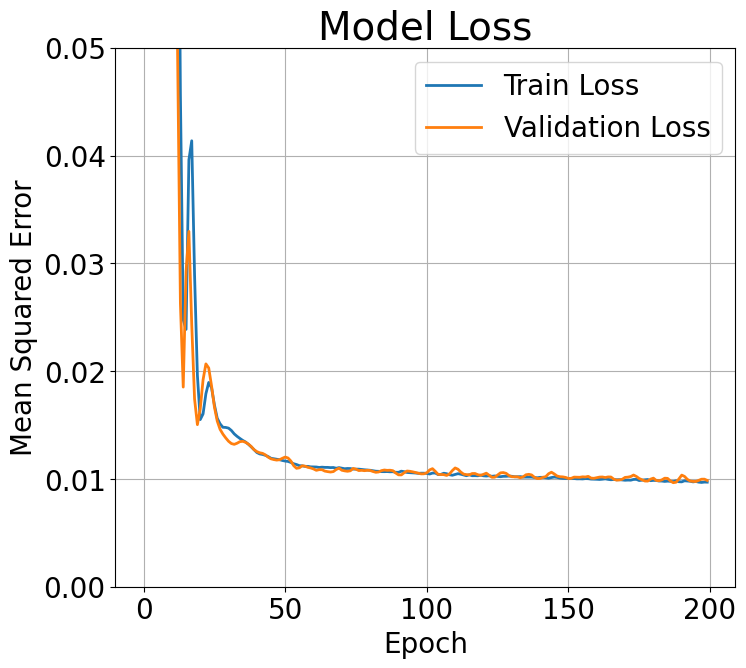

In [43]:
# Plot training & validation loss values
plt.rcParams.update({
    'font.size': 20,         # Base font size
    'axes.titlesize': 28,    # Title font size
    'axes.labelsize': 20,    # Axis label font size
    'xtick.labelsize': 20,   # X-axis tick font size
    'ytick.labelsize': 20,   # Y-axis tick font size
    'legend.fontsize': 20,   # Legend font size
    'figure.figsize': (8, 7),   # Default figure size
    'axes.grid': True,          # Enable grid by default
    'lines.linewidth': 2,       # Line thickness
    'lines.markersize': 6       # Marker size if used
})

plt.figure(figsize=(8, 7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.ylim(0, 0.05)  # Set y-axis from 0 to 0.05
plt.legend()
plt.grid(True)
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
                 True value  Predicted value
True value         1.000000         0.994924
Predicted value    0.994924         1.000000


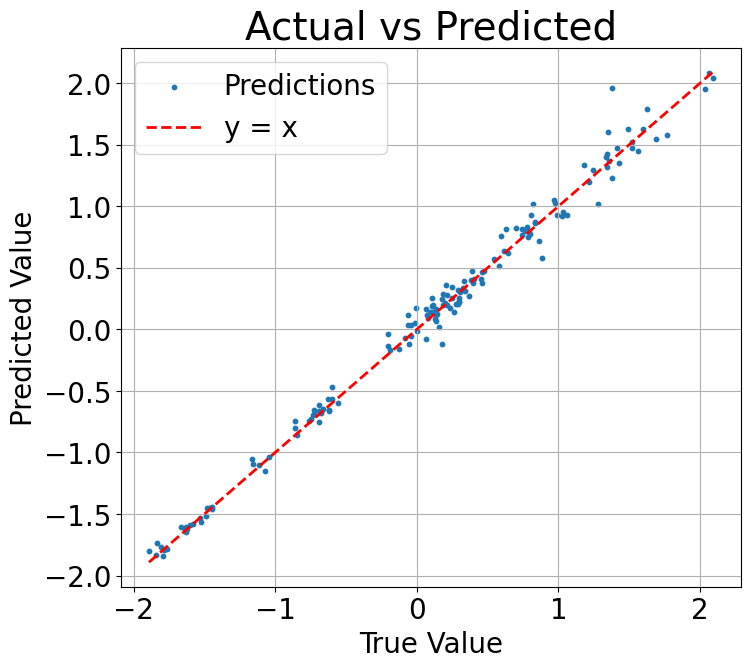

Mean Absolue Error (MAE): 0.0679


In [44]:
# Make predictions
yM_pred = modelM.predict(XM_test)
yM_pred_Tesla = yM_pred[:, Target_IDX]

# Correlation coefficient
corr_matrix = np.corrcoef(yM_test[:, Target_IDX], yM_pred_Tesla.flatten())

# Convert to a pandas DataFrame with labeled rows and columns
df_corr = pd.DataFrame(
    corr_matrix,
    index=["True value", "Predicted value"],
    columns=["True value", "Predicted value"]
)

print(df_corr)

# Plot actual vs predicted values

plt.scatter(yM_test[:, Target_IDX], yM_pred_Tesla, s=10, label='Predictions')
plt.plot([min(yM_test[:, Target_IDX]), max(yM_test[:, Target_IDX])],
         [min(yM_test[:, Target_IDX]), max(yM_test[:, Target_IDX])],
         'r--', label='y = x')  # Red dashed line
plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.legend()
plt.grid(True)
plt.title("Actual vs Predicted")
plt.show()

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(yM_test[:, Target_IDX], yM_pred_Tesla)

print(f"Mean Absolue Error (MAE): {mae:.4f}")

In [45]:
# trading simulation
Init_cap = 1000000 # initial capital is 1 million dollars.
St_volM = [0] # index 0: initial stock volume, index 1: stock volume after the 1st day trading ...
balanceM = [Init_cap] # index 0: initial balance, index 1: balance after the 1st day trading ...
St_predM = np.array(yM_future_Unscale[0:1])
NetAssetM = [Init_cap]

for i in range(XM_future.shape[0]):
  y_pred_scaled = modelM.predict(XM_future[i:i+1], verbose=0)
  y_pred_unscaled = scalerM.inverse_transform(y_pred_scaled)
  St_predM=np.vstack([St_predM,y_pred_unscaled]) # X_future[i:i+1]: slicing X_future between i-th row and i+1-th row, not including i+1-th row.
  if St_predM[i+1,Target_IDX]>yM_future_Unscale[i,Target_IDX]:
    St_change = balanceM[i]//yM_future_Unscale[i,Target_IDX] # quotient of a division
    Rem_balance = balanceM[i]%yM_future_Unscale[i,Target_IDX] # remainder of a division
    St_volM.append(St_volM[i]+St_change)
    balanceM.append(Rem_balance)
    NetAssetM.append(balanceM[i+1]+St_volM[i+1]*yM_future_Unscale[i,Target_IDX])
  else:
    balanceM.append(balanceM[i]+St_volM[i]*yM_future_Unscale[i,Target_IDX])
    St_volM.append(0)
    NetAssetM.append(balanceM[i+1]+St_volM[i+1]*yM_future_Unscale[i,Target_IDX])

Total profit or loss = 745932.7899999998


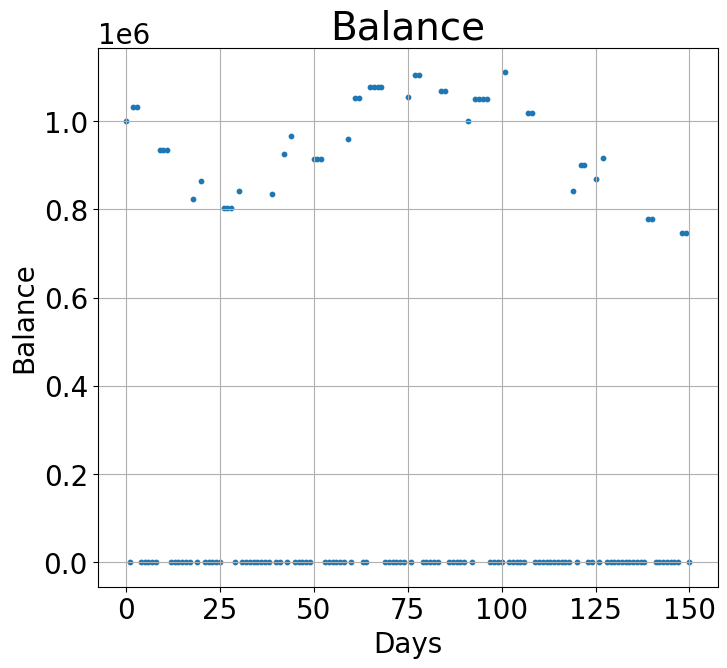

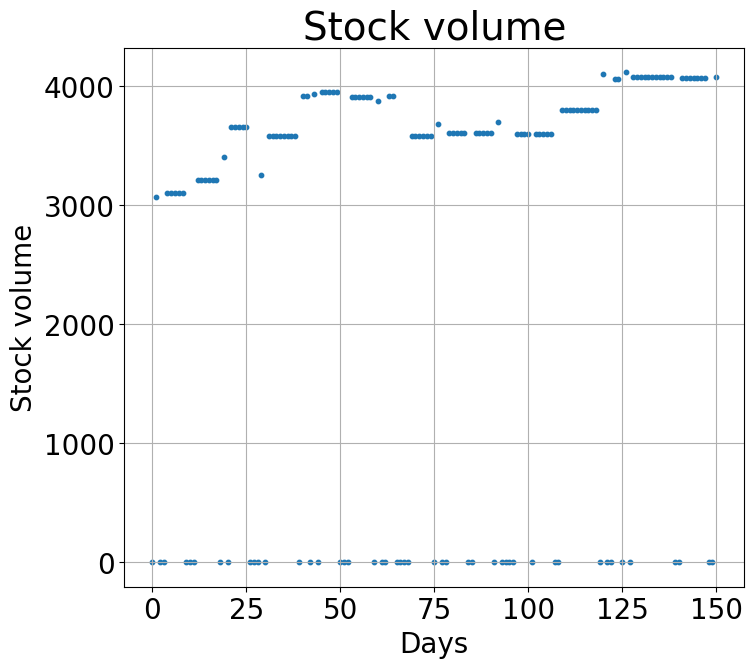

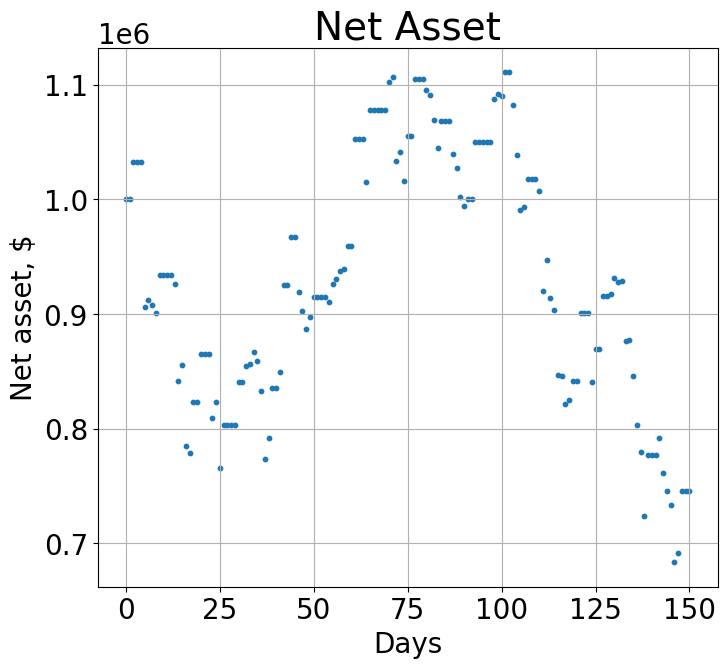

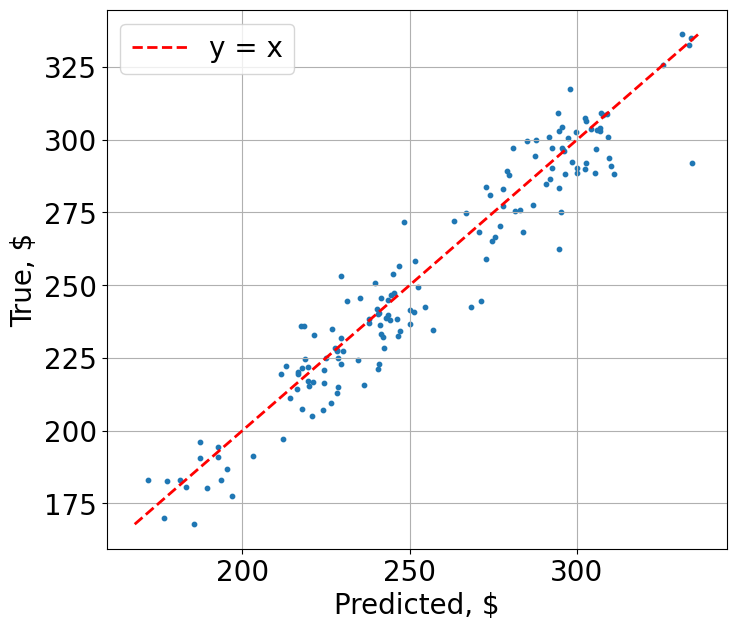

                 True value  Predicted value
True value         1.000000         0.962289
Predicted value    0.962289         1.000000
Mean Absolute Error (MSE): 8.7341


In [46]:

print("Total profit or loss =", NetAssetM[-1])

# First plot
plt.figure()
plt.scatter(range(len(balanceM)), balanceM, s=10)
plt.title("Balance")
plt.xlabel("Days")
plt.ylabel("Balance")
plt.grid(True)

# Second plot
plt.figure()
plt.scatter(range(len(St_volM)), St_volM, s=10)
plt.title("Stock volume")
plt.xlabel("Days")
plt.ylabel("Stock volume")
plt.grid(True)

# Third plot
plt.figure()
plt.scatter(range(len(NetAssetM)), NetAssetM, s=10)
plt.title("Net Asset")
plt.xlabel("Days")
plt.ylabel("Net asset, $")
plt.grid(True)

# Fourth plot
plt.figure()
plt.scatter(St_predM[:, Target_IDX], yM_future_Unscale[:, Target_IDX], s=10)

# Get the min and max range for the diagonal line
min_val = min(St_predM[:, Target_IDX].min(), yM_future_Unscale[:, Target_IDX].min())
max_val = max(St_predM[:, Target_IDX].max(), yM_future_Unscale[:, Target_IDX].max())

# Plot y = x line
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')

plt.xlabel("Predicted, $")
plt.ylabel("True, $")
plt.legend()
plt.grid(True)
plt.show()

# Make predictions

# Correlation coefficient
corr_matrix = np.corrcoef(St_predM[:, Target_IDX], yM_future_Unscale[:, Target_IDX])

# Convert to a pandas DataFrame with labeled rows and columns
df_corr = pd.DataFrame(
    corr_matrix,
    index=["True value", "Predicted value"],
    columns=["True value", "Predicted value"]
)

print(df_corr)

mae = mean_absolute_error(yM_future_Unscale[:, Target_IDX], St_predM[:, Target_IDX])

print(f"Mean Absolute Error (MSE): {mae:.4f}")

In [47]:
# trading simulation
Init_cap = 1000000 # initial capital is 1 million dollars.
St_volM = [0] # index 0: initial stock volume, index 1: stock volume after the 1st day trading ...
balanceM = [Init_cap] # index 0: initial balance, index 1: balance after the 1st day trading ...
St_predM = np.array(yM_future_Unscale[0:1])
NetAssetM = [Init_cap]

Lim_up = 1.015

for i in range(XM_future.shape[0]):
  y_pred_scaled = modelM.predict(XM_future[i:i+1], verbose=0)
  y_pred_unscaled = scalerM.inverse_transform(y_pred_scaled)
  St_predM=np.vstack([St_predM,y_pred_unscaled]) # X_future[i:i+1]: slicing X_future between i-th row and i+1-th row, not including i+1-th row.
  if St_predM[i+1,Target_IDX]>yM_future_Unscale[i,Target_IDX]*Lim_up:
    St_change = balanceM[i]//yM_future_Unscale[i,Target_IDX] # quotient of a division
    Rem_balance = balanceM[i]%yM_future_Unscale[i,Target_IDX] # remainder of a division
    St_volM.append(St_volM[i]+St_change)
    balanceM.append(Rem_balance)
    NetAssetM.append(balanceM[i+1]+St_volM[i+1]*yM_future_Unscale[i,Target_IDX])
  else:
    balanceM.append(balanceM[i]+St_volM[i]*yM_future_Unscale[i,Target_IDX])
    St_volM.append(0)
    NetAssetM.append(balanceM[i+1]+St_volM[i+1]*yM_future_Unscale[i,Target_IDX])

Total profit or loss = 891256.5799999996


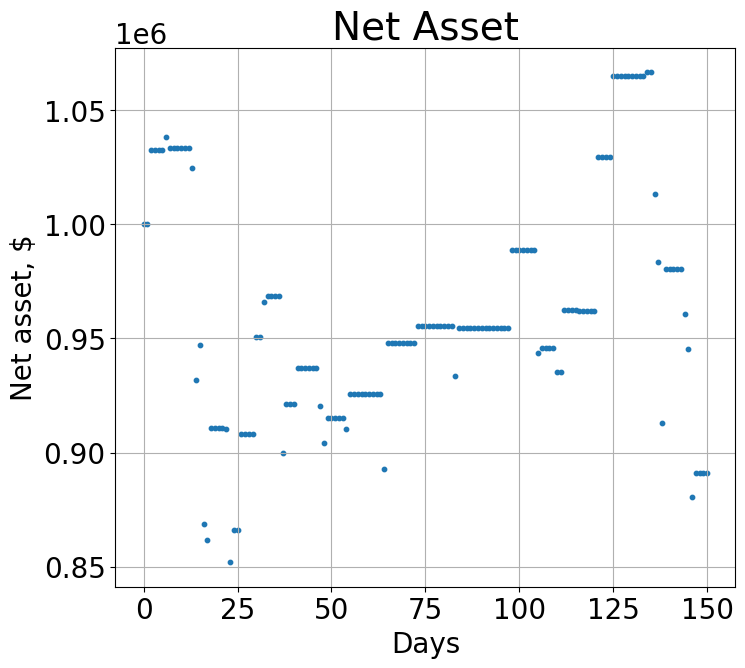

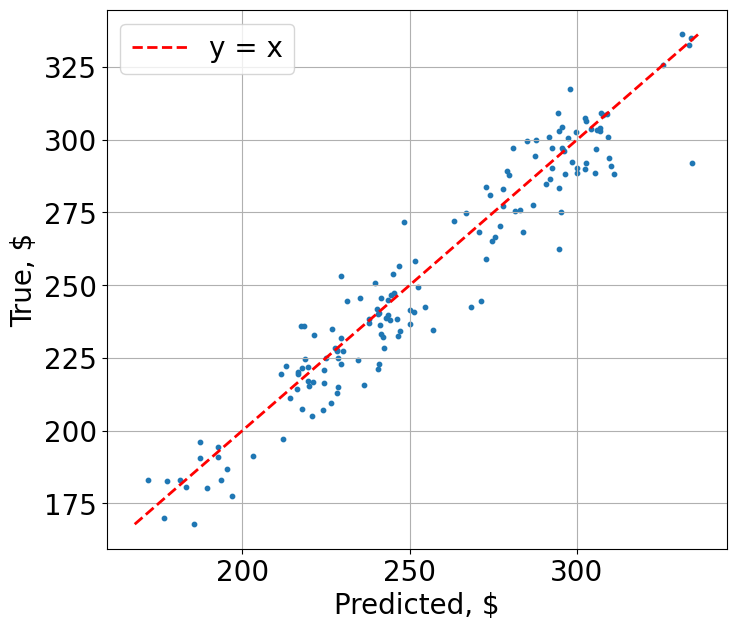

In [48]:
# Third plot
plt.figure()
plt.scatter(range(len(NetAssetM)), NetAssetM, s=10)
plt.title("Net Asset")
plt.xlabel("Days")
plt.ylabel("Net asset, $")
plt.grid(True)

print("Total profit or loss =", NetAssetM[-1])

# Fourth plot
plt.figure()
plt.scatter(St_predM[:, Target_IDX], yM_future_Unscale[:, Target_IDX], s=10)

# Get the min and max range for the diagonal line
min_val = min(St_predM[:, Target_IDX].min(), yM_future_Unscale[:, Target_IDX].min())
max_val = max(St_predM[:, Target_IDX].max(), yM_future_Unscale[:, Target_IDX].max())

# Plot y = x line
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')

plt.xlabel("Predicted, $")
plt.ylabel("True, $")
plt.legend()
plt.grid(True)
plt.show()

plt.show()

In [49]:
# trading simulation
Init_cap = 1000000 # initial capital is 1 million dollars.
St_volM = [0] # index 0: initial stock volume, index 1: stock volume after the 1st day trading ...
balanceM = [Init_cap] # index 0: initial balance, index 1: balance after the 1st day trading ...
St_predM = np.array(yM_future_Unscale[0:1])
NetAssetM = [Init_cap]

Lim_up = 1.03

for i in range(XM_future.shape[0]):
  y_pred_scaled = modelM.predict(XM_future[i:i+1], verbose=0)
  y_pred_unscaled = scalerM.inverse_transform(y_pred_scaled)
  St_predM=np.vstack([St_predM,y_pred_unscaled]) # X_future[i:i+1]: slicing X_future between i-th row and i+1-th row, not including i+1-th row.
  if St_predM[i+1,Target_IDX]>yM_future_Unscale[i,Target_IDX]*Lim_up:
    St_change = balanceM[i]//yM_future_Unscale[i,Target_IDX] # quotient of a division
    Rem_balance = balanceM[i]%yM_future_Unscale[i,Target_IDX] # remainder of a division
    St_volM.append(St_volM[i]+St_change)
    balanceM.append(Rem_balance)
    NetAssetM.append(balanceM[i+1]+St_volM[i+1]*yM_future_Unscale[i,Target_IDX])
  else:
    balanceM.append(balanceM[i]+St_volM[i]*yM_future_Unscale[i,Target_IDX])
    St_volM.append(0)
    NetAssetM.append(balanceM[i+1]+St_volM[i+1]*yM_future_Unscale[i,Target_IDX])


Total profit or loss = 1274642.8499999996


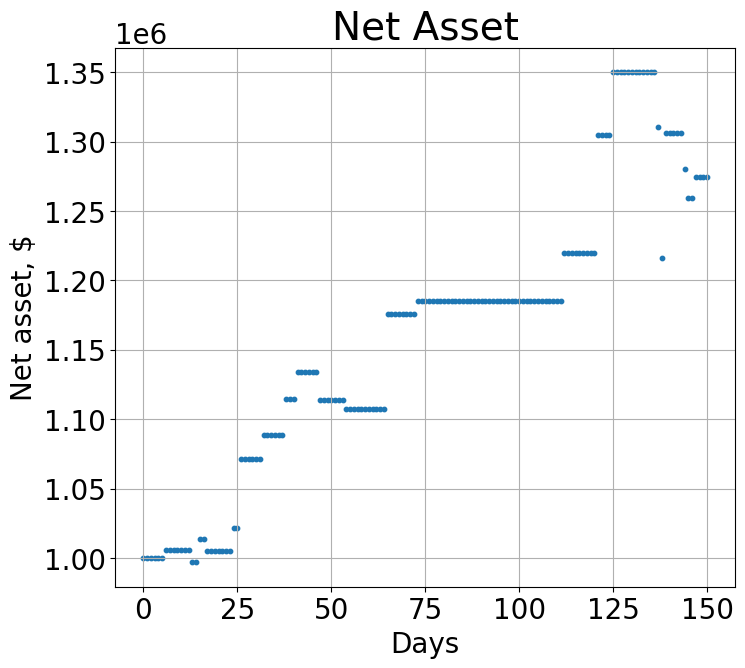

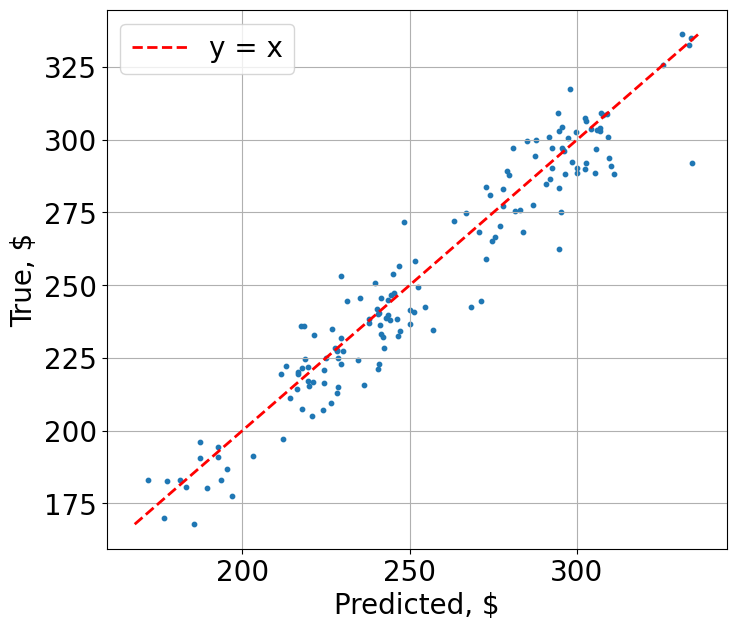

In [50]:
# Third plot
plt.figure()
plt.scatter(range(len(NetAssetM)), NetAssetM, s=10)
plt.title("Net Asset")
plt.xlabel("Days")
plt.ylabel("Net asset, $")
plt.grid(True)

print("Total profit or loss =", NetAssetM[-1])

# Fourth plot
plt.figure()
plt.scatter(St_predM[:, Target_IDX], yM_future_Unscale[:, Target_IDX], s=10)

# Get the min and max range for the diagonal line
min_val = min(St_predM[:, Target_IDX].min(), yM_future_Unscale[:, Target_IDX].min())
max_val = max(St_predM[:, Target_IDX].max(), yM_future_Unscale[:, Target_IDX].max())

# Plot y = x line
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')

plt.xlabel("Predicted, $")
plt.ylabel("True, $")
plt.legend()
plt.grid(True)
plt.show()

plt.show()